In [1]:
#!pip install torch torchvision torchaudio
import torch
print('gpu?'+str(torch.cuda.is_available()))

gpu?True


## Colab Configuration

In [2]:
names=['Opening the door and walking in/out',
        'Putting on a jacket',
        'Touching a hot surface',
        'Opening the fridge',
        'Drinking water',
        'Colliding against something',
        'Eating food with a fork',
        'Coughing or sneezing',
        'Wiping a table',
        'Reading a book',
        'Neck roll exercise',
        'Freehand exercise',
        'Lying down',
        'Limping',
        'Talking on the phone',
        'Using a computer',
        'Falling down',
        'Brushing teeth',
        'Writing',
        'Unknown activity']

The next code is adapted from (higgingFace->VideMAE-> VideoMAEForVideoClassification)[https://huggingface.co/docs/transformers/main/en/model_doc/videomae#transformers.VideoMAEForVideoClassification]

In [3]:
from decord import VideoReader, cpu
from transformers import VideoMAEFeatureExtractor, VideoMAEForPreTraining,VideoMAEConfig,VideoMAEForVideoClassification
import numpy as np
import torch
import os
import json
import csv #I make in a venv here more easy pandas...

In [4]:
name_model="MCG-NJU/videomae-base-finetuned-kinetics"
#name_model="MCG-NJU/videomae-base"
feature_extractor = VideoMAEFeatureExtractor.from_pretrained(name_model)
output=json.load(open('training_labels.json'))
validation_labels = json.load(open('validation_labels.json'))
path='training_set'
validation_path='validation_set'

## Fine tuning VideoMAE

Fine tuning is the gold of transformers, from few videos/images/sentences we can make a classifier.

VideoMAE is based of a ImageMAE which is based in ViT (Vision Transformer), which is Based in Transformers, so let try.




### Create DataSet

based in [image dataset](https://huggingface.co/docs/datasets/image_dataset). I think that it is not used in the best way the library [link text](https://huggingface.co/course/chapter5/4?fw=pt)

In [5]:
from datasets import Dataset
import numpy as np

my_set=[{'file_name':path+'/'+a,'labels':output[a][0],'description':names[output[a][0]]} for a in output.keys()]
validation_set=[{'file_name':validation_path+'/'+a,'labels':validation_labels[a][0],'description':names[validation_labels[a][0]]} for a in validation_labels.keys()]

In [6]:
from tqdm.notebook import tqdm

augmented_set = []
for elem in tqdm(my_set):
    file_path = elem['file_name']
    videoreader = VideoReader(file_path, num_threads=1, ctx=cpu(0))
    videoreader.seek(0)
    file_size = len(videoreader)
    batches = int(file_size/16)
    for i in range(batches):
        new_elem = {}
        new_elem['file_name'] = file_path + '@' + str(i)
        new_elem['labels'] = elem['labels']
        augmented_set.append(new_elem)

  0%|          | 0/792 [00:00<?, ?it/s]

In [7]:
augmented_validation_set = []
for elem in tqdm(validation_set):
    file_path = elem['file_name']
    videoreader = VideoReader(file_path, num_threads=1, ctx=cpu(0))
    videoreader.seek(0)
    file_size = len(videoreader)
    batches = int(file_size/16)
    for i in range(batches):
        new_elem = {}
        new_elem['file_name'] = file_path + '@' + str(i)
        new_elem['labels'] = elem['labels']
        augmented_validation_set.append(new_elem)

  0%|          | 0/136 [00:00<?, ?it/s]

In [8]:
len(augmented_set)

7148

In [9]:
len(augmented_validation_set)

1220

In [10]:
# from sklearn.model_selection import train_test_split
# my_set_trian,my_set_val =train_test_split(augmented_set, test_size=0.2, random_state=42)

In [11]:
# all_set = {}
# full_train_set = {}

# all_set['train'] = my_set_trian
# all_set['validation'] = my_set_val
# full_train_set['train'] = augmented_set

full_augmented_set = {}
full_augmented_set['train'] = augmented_set
full_augmented_set['validation'] = augmented_validation_set

with open("train_augmented.json", "w") as final:
    json.dump(full_augmented_set, final)
    
# with open("full_train.json", "w") as final:
#     json.dump(full_train_set, final)


In [12]:
# dataset = Dataset.from_json('train.json',field='train')
# dataset_validation = Dataset.from_json('train.json',field='validation')
# dataset_full = Dataset.from_json('full_train.json', field='train')
dataset = Dataset.from_json('train_augmented.json',field='train')
dataset_validation = Dataset.from_json('train_augmented.json',field='validation')

Using custom data configuration default-27712e88fc2a575c


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Using custom data configuration default-99d1998bd928da80


Dataset json downloaded and prepared to /home/tomas/.cache/huggingface/datasets/json/default-27712e88fc2a575c/0.0.0. Subsequent calls will reuse this data.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /home/tomas/.cache/huggingface/datasets/json/default-99d1998bd928da80/0.0.0. Subsequent calls will reuse this data.


In [13]:
dataset[0]


{'file_name': 'training_set/video0000.mp4@0', 'labels': 14}

In [14]:
# for i in range(int(144/16)):
#     sub = int(144/16)
#     indices = np.linspace(i, 144-sub+i, num=16)
#     indices = np.clip(indices, 0, 144- 1).astype(np.int64)
#     print(indices)

In [15]:
# def multi_sample(pre_dataset):
#     new_dataset = []
#     for elem in tqdm(pre_dataset):
#         file_path = elem['file_name']
#         videoreader = VideoReader(file_path, num_threads=1, ctx=cpu(0))
#         videoreader.seek(0)
#         file_size = len(videoreader)
#         batches = int(file_size/16)
#         for i in range(batches):
#             indices = np.linspace(i, len(videoreader)-batches+i, num=16)
#             indices = np.clip(indices, 0, len(videoreader)- 1).astype(np.int64)
#             output = {}
#             output['pixel_values'] = feature_extractor(list(videoreader.get_batch(indices).asnumpy()), return_tensors="pt")['pixel_values'][0]
#             output['labels'] = elem['labels']
#             new_dataset.append(output)
#     return new_dataset

In [16]:
# prepared_train = multi_sample(dataset)
# prepared_validation = multi_sample(dataset_validation)
# prepared_full = multi_sample(dataset_full)
# TAKES TOO MUCH RAM, IMMPOSIBLE

In [17]:
# def transform(sample):
#     """
#     TODO: test different sampling methods
#     """
#     inputs=[]
    
#     for s in sample['file_name']:
#       videoreader = VideoReader(s, num_threads=1, ctx=cpu(0))
#       videoreader.seek(0)
#       #indices = sample_frame_indices(clip_len=16, frame_sample_rate=4, seg_len=len(videoreader))
#       indices = np.linspace(0, len(videoreader), num=16)
#       indices = np.clip(indices, 0, len(videoreader)- 1).astype(np.int64)
#       inputs.append(feature_extractor(list(videoreader.get_batch(indices).asnumpy()), return_tensors="pt")['pixel_values'][0])
#     output={}  
#     output['pixel_values'] =inputs 
#     # Don't forget to include the labels!
#     output['labels'] = sample['labels']
#     return output

In [18]:
# prepared_train = dataset.with_transform(transform)
# prepared_validation = dataset_validation.with_transform(transform)
# prepared_full = dataset_full.with_transform(transform)

In [19]:
# prepared_train[0]

In [35]:
import cv2 as cv

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )
# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

def optical_flow(video):
    temp_video = videoreader[:].asnumpy()
    old_gray = cv.cvtColor(temp_video[0], cv.COLOR_BGR2GRAY)
    p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
    output = []
    for frame in temp_video[1:]:
        frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        # calculate optical flow
        p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
        # Select good points
        mask = np.zeros_like(old_gray)
        if p1 is not None:
            good_new = p1[st==1]
            good_old = p0[st==1]
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            mask = cv.line(mask, (int(a), int(b)), (int(c), int(d)), 255, 2)
            mask = cv.circle(mask, (int(a), int(b)), 5, 255, -1)
        # Now update the previous frame and previous points
        output.append(mask)
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1, 1, 2)
    return np.asarray(output)


In [36]:
videoreader = VideoReader(my_set[0]['file_name'], num_threads=1, ctx=cpu(0))
videoreader.seek(0)

optical_output = optical_flow(videoreader[:].asnumpy())

(140, 480, 640, 3)
(139, 480, 640)


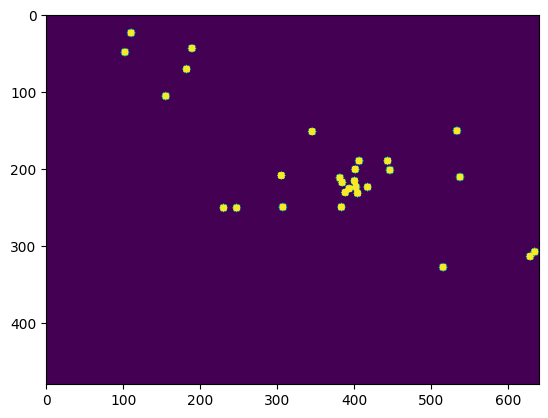

In [66]:
import matplotlib.pyplot as plt
print(videoreader[:].asnumpy().shape)
print(optical_output.shape)
plt.imshow(optical_output[0])

### Training and validation

Based in [Fine tuning ViT](https://huggingface.co/blog/fine-tune-vit)

In [20]:
import torch

# def collate_fn(batch):
    
#     return {
#         'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
#         'labels': torch.tensor([x['labels'] for x in batch])
#     }

In [21]:
# def collate_multi_with_path_batches(batch):
#     pixel_values = []
#     labels = []
#     for elem in batch:
#         file_path = elem['file_name']
#         videoreader = VideoReader(file_path, num_threads=1, ctx=cpu(0))
#         videoreader.seek(0)
#         file_size = len(videoreader)
#         batches = int(file_size/16)
#         for i in range(batches):
#             indices = np.linspace(i, len(videoreader)-batches+i, num=16)
#             indices = np.clip(indices, 0, len(videoreader)- 1).astype(np.int64)
#             pixel_values.append(feature_extractor(list(videoreader.get_batch(indices).asnumpy()), return_tensors="pt")['pixel_values'][0])
#             labels.append(elem['labels'])
#     return {
#         'pixel_values': torch.stack(pixel_values),
#         'labels': torch.tensor(labels)
#     }
    
    

In [22]:
def collate_with_path_batches(batch):
    pixel_values = []
    labels = []
    for elem in batch:
        file_path, i = elem['file_name'].split('@')
        i = int(i)
        videoreader = VideoReader(file_path, num_threads=1, ctx=cpu(0))
        videoreader.seek(0)
        file_size = len(videoreader)
        batches = int(file_size/16)
        indices = np.linspace(i, len(videoreader)-batches+i, num=16)
        indices = np.clip(indices, 0, len(videoreader)- 1).astype(np.int64)
        pixel_values.append(feature_extractor(list(videoreader.get_batch(indices).asnumpy()), return_tensors="pt")['pixel_values'][0])
        labels.append(elem['labels'])
    return {
        'pixel_values': torch.stack(pixel_values),
        'labels': torch.tensor(labels)
    }

In [23]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

/tmp/ipykernel_3808937/2425197347.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [24]:
labels = names

model = VideoMAEForVideoClassification.from_pretrained(
    name_model,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
#     patch_size = 32,
#     num_frames = 64
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([20, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([20]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
for name, param in model.named_parameters():
    if param.requires_grad:
        if 'videomae' in name or 'fc_norm' in name:
            param.requires_grad = False
            
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         if 'videomae' in name:
#             param.requires_grad = False
            
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name)

classifier.weight
classifier.bias


In [26]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./videomae-icsr-heart",
  per_device_train_batch_size=16,
  per_device_eval_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=12,
  fp16=True,
  save_steps=50,
  eval_steps=50,
  logging_steps=50,
#   weight_decay =0.05,
#   learning_rate=1e-5,
  save_total_limit=5,
  remove_unused_columns=False,
  push_to_hub=False,
  #report_to='tensorboard',
  load_best_model_at_end=True,
)

In [27]:
# from transformers import TrainingArguments

# training_args = TrainingArguments(
#   output_dir="./videomae-icsr-heart",
#   per_device_train_batch_size=2,
#   num_train_epochs=16,
#   save_steps=198,
#   logging_steps=198,
#   save_total_limit=5,
#   remove_unused_columns=False,
# )

In [28]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_with_path_batches,
    compute_metrics=compute_metrics,
    train_dataset=dataset,
    eval_dataset=dataset_validation,
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [29]:
torch.cuda.empty_cache()

In [30]:
train_results = trainer.train()

/home/tomas/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7148
  Num Epochs = 12
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5364
  Number of trainable parameters = 15380


Step,Training Loss,Validation Loss,Accuracy
50,2.837000,2.876852,0.113115
100,2.663000,2.762153,0.163115
150,2.508600,2.663036,0.204918
200,2.337300,2.568589,0.259836
250,2.224900,2.485153,0.336066
300,2.107300,2.410009,0.395902
350,1.993100,2.335044,0.444262
400,1.881200,2.268728,0.483607
450,1.787800,2.205790,0.501639
500,1.692900,2.146368,0.512295


***** Running Evaluation *****
  Num examples = 1220
  Batch size = 16
Saving model checkpoint to ./videomae-icsr-heart/checkpoint-50
Configuration saved in ./videomae-icsr-heart/checkpoint-50/config.json
Model weights saved in ./videomae-icsr-heart/checkpoint-50/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart/checkpoint-50/preprocessor_config.json
Deleting older checkpoint [videomae-icsr-heart/checkpoint-2100] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1220
  Batch size = 16
Saving model checkpoint to ./videomae-icsr-heart/checkpoint-100
Configuration saved in ./videomae-icsr-heart/checkpoint-100/config.json
Model weights saved in ./videomae-icsr-heart/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart/checkpoint-100/preprocessor_config.json
Deleting older checkpoint [videomae-icsr-heart/checkpoint-5200] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1220
  Batch size = 16

Feature extractor saved in ./videomae-icsr-heart/checkpoint-900/preprocessor_config.json
Deleting older checkpoint [videomae-icsr-heart/checkpoint-650] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1220
  Batch size = 16
Saving model checkpoint to ./videomae-icsr-heart/checkpoint-950
Configuration saved in ./videomae-icsr-heart/checkpoint-950/config.json
Model weights saved in ./videomae-icsr-heart/checkpoint-950/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart/checkpoint-950/preprocessor_config.json
Deleting older checkpoint [videomae-icsr-heart/checkpoint-700] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1220
  Batch size = 16
Saving model checkpoint to ./videomae-icsr-heart/checkpoint-1000
Configuration saved in ./videomae-icsr-heart/checkpoint-1000/config.json
Model weights saved in ./videomae-icsr-heart/checkpoint-1000/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart/checkpoint-1000/

  Num examples = 1220
  Batch size = 16
Saving model checkpoint to ./videomae-icsr-heart/checkpoint-1800
Configuration saved in ./videomae-icsr-heart/checkpoint-1800/config.json
Model weights saved in ./videomae-icsr-heart/checkpoint-1800/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart/checkpoint-1800/preprocessor_config.json
Deleting older checkpoint [videomae-icsr-heart/checkpoint-1550] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1220
  Batch size = 16
Saving model checkpoint to ./videomae-icsr-heart/checkpoint-1850
Configuration saved in ./videomae-icsr-heart/checkpoint-1850/config.json
Model weights saved in ./videomae-icsr-heart/checkpoint-1850/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart/checkpoint-1850/preprocessor_config.json
Deleting older checkpoint [videomae-icsr-heart/checkpoint-1600] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1220
  Batch size = 16
Saving model check

Feature extractor saved in ./videomae-icsr-heart/checkpoint-2650/preprocessor_config.json
Deleting older checkpoint [videomae-icsr-heart/checkpoint-2400] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1220
  Batch size = 16
Saving model checkpoint to ./videomae-icsr-heart/checkpoint-2700
Configuration saved in ./videomae-icsr-heart/checkpoint-2700/config.json
Model weights saved in ./videomae-icsr-heart/checkpoint-2700/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart/checkpoint-2700/preprocessor_config.json
Deleting older checkpoint [videomae-icsr-heart/checkpoint-2450] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1220
  Batch size = 16
Saving model checkpoint to ./videomae-icsr-heart/checkpoint-2750
Configuration saved in ./videomae-icsr-heart/checkpoint-2750/config.json
Model weights saved in ./videomae-icsr-heart/checkpoint-2750/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart/checkpoin

  Num examples = 1220
  Batch size = 16
Saving model checkpoint to ./videomae-icsr-heart/checkpoint-3550
Configuration saved in ./videomae-icsr-heart/checkpoint-3550/config.json
Model weights saved in ./videomae-icsr-heart/checkpoint-3550/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart/checkpoint-3550/preprocessor_config.json
Deleting older checkpoint [videomae-icsr-heart/checkpoint-3300] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1220
  Batch size = 16
Saving model checkpoint to ./videomae-icsr-heart/checkpoint-3600
Configuration saved in ./videomae-icsr-heart/checkpoint-3600/config.json
Model weights saved in ./videomae-icsr-heart/checkpoint-3600/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart/checkpoint-3600/preprocessor_config.json
Deleting older checkpoint [videomae-icsr-heart/checkpoint-3350] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1220
  Batch size = 16
Saving model check

Feature extractor saved in ./videomae-icsr-heart/checkpoint-4400/preprocessor_config.json
Deleting older checkpoint [videomae-icsr-heart/checkpoint-4150] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1220
  Batch size = 16
Saving model checkpoint to ./videomae-icsr-heart/checkpoint-4450
Configuration saved in ./videomae-icsr-heart/checkpoint-4450/config.json
Model weights saved in ./videomae-icsr-heart/checkpoint-4450/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart/checkpoint-4450/preprocessor_config.json
Deleting older checkpoint [videomae-icsr-heart/checkpoint-4200] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1220
  Batch size = 16
Saving model checkpoint to ./videomae-icsr-heart/checkpoint-4500
Configuration saved in ./videomae-icsr-heart/checkpoint-4500/config.json
Model weights saved in ./videomae-icsr-heart/checkpoint-4500/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart/checkpoin

  Num examples = 1220
  Batch size = 16
Saving model checkpoint to ./videomae-icsr-heart/checkpoint-5300
Configuration saved in ./videomae-icsr-heart/checkpoint-5300/config.json
Model weights saved in ./videomae-icsr-heart/checkpoint-5300/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart/checkpoint-5300/preprocessor_config.json
Deleting older checkpoint [videomae-icsr-heart/checkpoint-5050] due to args.save_total_limit
***** Running Evaluation *****
  Num examples = 1220
  Batch size = 16
Saving model checkpoint to ./videomae-icsr-heart/checkpoint-5350
Configuration saved in ./videomae-icsr-heart/checkpoint-5350/config.json
Model weights saved in ./videomae-icsr-heart/checkpoint-5350/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart/checkpoint-5350/preprocessor_config.json
Deleting older checkpoint [videomae-icsr-heart/checkpoint-5100] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loa

In [42]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Saving model checkpoint to ./videomae-icsr-heart
Configuration saved in ./videomae-icsr-heart/config.json
Model weights saved in ./videomae-icsr-heart/pytorch_model.bin
Feature extractor saved in ./videomae-icsr-heart/preprocessor_config.json


***** train metrics *****
  epoch                    =           4.0
  total_flos               = 33186001607GF
  train_loss               =         1.424
  train_runtime            =    1:07:49.50
  train_samples_per_second =         7.026
  train_steps_per_second   =          0.22


In [ ]:
metrics = trainer.evaluate(dataset_validation)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

In [30]:
metrics

NameError: name 'metrics' is not defined

In [54]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "video-classification",
    "dataset": 'HEART-MET',
    "tags": ['video-classification'],
}

trainer.create_model_card(**kwargs)

In [50]:
#!cp -R /content/videomae-icsr-heart/ /content/drive/MyDrive/ICSR 2022 HEART-MET Activity Recognition Challenge/models
# !cp -R /content/videomae-icsr-heart/ /content/drive/MyDrive/models/

## testing

In [139]:
# prepared_validation.to_json('/content/validation_set.csv')

In [34]:
prepared_train.to_json('/content/training_set.csv')

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

56355

In [ ]:
data['pixel_values']

In [141]:
i=0
predicted=[]
for data in all_set['validation']:
  #if i==2:
  #  break
  i+=1
  videoreader = VideoReader(data['file_name'], num_threads=1, ctx=cpu(0))
  videoreader.seek(0)
  #indices = sample_frame_indices(clip_len=16, frame_sample_rate=4, seg_len=len(videoreader))
  indices = np.linspace(0, len(videoreader), num=16)
  indices = np.clip(indices, 0, len(videoreader)- 1).astype(np.int64)
  pixel_values = feature_extractor(list(videoreader.get_batch(indices).asnumpy()), return_tensors="pt")
  pixel_values = pixel_values.to('cuda')
  with torch.no_grad():
        outputs = model(**pixel_values)#
        pred=outputs.logits.argmax(-1).item()
        predicted.append([data['file_name'],data['labels'],data['description'],pred])
        print(data['labels'],pred)
  



6 6
4 4
12 12
8 8
9 9
15 15
6 6
0 0
8 8
18 18
15 15
8 8
15 15
17 17
17 17
6 6
4 4
4 4
1 1
8 8
14 14
12 12
7 7
12 12
4 4
4 4
15 15
17 17
11 11
12 12
14 14
18 18
6 6
19 19
6 6
14 14
5 5
15 15
6 6
6 6
6 6
1 1
4 4
12 12
18 18
7 7
13 13
0 0
3 3
6 6
9 9
15 15
14 14
17 17
9 9
6 6
17 17


KeyboardInterrupt: 

In [44]:
import pandas as pd
df = pd.DataFrame(predicted,columns=['file','label','description','predicted'])

df

,file,label,description,predicted
0,training_set/video0694.mp4,6,Eating food with a fork,6
1,training_set/video0528.mp4,4,Drinking water,4
2,training_set/video0598.mp4,12,Lying down,12
3,training_set/video0606.mp4,8,Wiping a table,7
4,training_set/video0120.mp4,9,Reading a book,9
...,...,...,...,...
154,training_set/video0433.mp4,15,Using a computer,15
155,training_set/video0467.mp4,17,Brushing teeth,17
156,training_set/video0361.mp4,12,Lying down,12
157,training_set/video0079.mp4,1,Putting on a jacket,1


In [45]:
from sklearn.metrics import classification_report

print(classification_report(df['label'], df['predicted'], target_names=names))


                                     precision    recall  f1-score   support

Opening the door and walking in/out       1.00      1.00      1.00         7
                Putting on a jacket       1.00      0.88      0.93         8
             Touching a hot surface       0.75      1.00      0.86         3
                 Opening the fridge       1.00      1.00      1.00         3
                     Drinking water       1.00      1.00      1.00        15
        Colliding against something       0.50      1.00      0.67         2
            Eating food with a fork       0.94      0.84      0.89        19
               Coughing or sneezing       0.50      1.00      0.67         4
                     Wiping a table       1.00      0.83      0.91         6
                     Reading a book       0.90      1.00      0.95         9
                 Neck roll exercise       1.00      1.00      1.00         5
                  Freehand exercise       1.00      1.00      1.00         

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


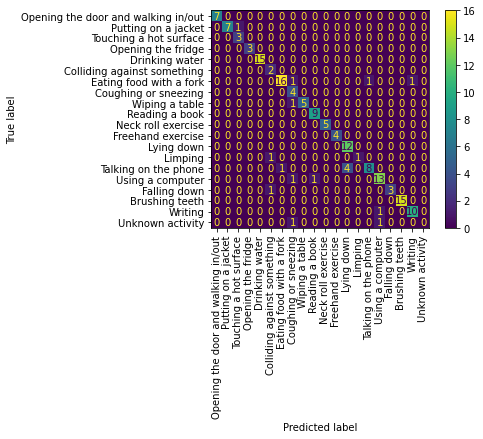

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,ConfusionMatrixDisplay
cm = confusion_matrix(df['label'], df['predicted'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=names)
disp.plot(xticks_rotation='vertical')

In [45]:
from os import listdir
from os.path import isfile, join
validation_path = "test_set"
onlyfiles = [f for f in listdir(validation_path) if isfile(join(validation_path, f))]

In [46]:
onlyfiles

['video0029.mp4',
 'video0023.mp4',
 'video0054.mp4',
 'video0050.mp4',
 'video0179.mp4',
 'video0209.mp4',
 'video0038.mp4',
 'video0169.mp4',
 'video0141.mp4',
 'video0233.mp4',
 'video0154.mp4',
 'video0090.mp4',
 'video0092.mp4',
 'video0063.mp4',
 'video0110.mp4',
 'video0022.mp4',
 'video0188.mp4',
 'video0117.mp4',
 'video0077.mp4',
 'video0087.mp4',
 'video0032.mp4',
 'video0145.mp4',
 'video0088.mp4',
 'video0098.mp4',
 'video0198.mp4',
 'video0005.mp4',
 'video0189.mp4',
 'video0210.mp4',
 'video0224.mp4',
 'video0159.mp4',
 'video0046.mp4',
 'video0089.mp4',
 'video0195.mp4',
 'video0231.mp4',
 'video0218.mp4',
 'video0144.mp4',
 'video0119.mp4',
 'video0105.mp4',
 'video0151.mp4',
 'video0150.mp4',
 'video0086.mp4',
 'video0148.mp4',
 'video0125.mp4',
 'video0237.mp4',
 'video0216.mp4',
 'video0001.mp4',
 'video0134.mp4',
 'video0011.mp4',
 'video0017.mp4',
 'video0109.mp4',
 'video0043.mp4',
 'video0149.mp4',
 'video0031.mp4',
 'video0018.mp4',
 'video0239.mp4',
 'video016

In [47]:
# model.load_state_dict(torch.load('videomae-icsr-heart/checkpoint-5000/pytorch_model.bin'))

In [48]:
# eval_results = {}
# for video in onlyfiles:
#     videoreader = VideoReader(validation_path + "/" + video, num_threads=1, ctx=cpu(0))
#     videoreader.seek(0)
#     indices = np.linspace(0, len(videoreader), num=128)
#     indices = np.clip(indices, 0, len(videoreader)- 1).astype(np.int64)
#     inputs = []
#     inputs.append(feature_extractor(list(videoreader.get_batch(indices).asnumpy()), return_tensors="pt")['pixel_values'][0])
#     inputs = torch.stack(inputs)
# #     print(inputs)
#     output = model(inputs.to(device='cuda'))
# #     print(names[torch.argmax(output['logits']).item()])
#     eval_results[video] = torch.argmax(output['logits']).item()
# eval_results
    

In [49]:
eval_results = {}
eval_labels = {}
eval_estimations = {}
for video in tqdm(onlyfiles):
    eval_estimations[video] = []
    videoreader = VideoReader(validation_path + "/" + video, num_threads=1, ctx=cpu(0))
    videoreader.seek(0)
    file_size = len(videoreader)
    batches = int(file_size/16)
    input_list = []
    for i in range(batches):
        indices = np.linspace(i, len(videoreader)-batches+i, num=16)
        indices = np.clip(indices, 0, len(videoreader)- 1).astype(np.int64)
        inputs = []
        inputs.append(feature_extractor(list(videoreader.get_batch(indices).asnumpy()), return_tensors="pt")['pixel_values'][0])
        input_list.append(torch.stack(inputs))
#     print(len(input_list))
    results = []
    for frame_seq in input_list:
        output = model(frame_seq.to(device='cuda'))
        eval_estimations[video].append(output['logits'])
        output = torch.argmax(output['logits']).item()
        results.append(output)
#     print(np.bincount(results).argmax())
    eval_results[video] = [np.bincount(results).argmax()]
    eval_labels[video] = results
#     print(names[torch.argmax(output['logits']).item()])
    
eval_results
    

  0%|          | 0/250 [00:00<?, ?it/s]

DECORDError: [11:27:42] /github/workspace/src/video/video_reader.cc:151: Check failed: st_nb >= 0 (-1381258232 vs. 0) ERROR cannot find video stream with wanted index: -1

In [64]:
for x in dict(sorted(eval_results.items(), key=lambda item: item)).keys():
    if eval_results[x] != validation_labels[x][0]:
        print(f'{x}, predicted {names[eval_results[x]]} vs real {names[validation_labels[x][0]]}, {eval_results[x]} vs {validation_labels[x][0]}, Posible cases: {eval_labels[x]}')

video0000.mp4, predicted Writing vs real Wiping a table, 18 vs 8, Posible cases: [8, 18, 8, 18, 8, 18, 18, 18, 18]
video0003.mp4, predicted Freehand exercise vs real Coughing or sneezing, 11 vs 7, Posible cases: [1, 1, 1, 1, 11, 11, 11, 11, 11]
video0009.mp4, predicted Touching a hot surface vs real Unknown activity, 2 vs 19, Posible cases: [2, 2, 2, 2, 2, 2, 2, 2, 2]
video0011.mp4, predicted Brushing teeth vs real Freehand exercise, 17 vs 11, Posible cases: [17, 17, 17, 17, 17, 17, 17, 17, 17]
video0014.mp4, predicted Eating food with a fork vs real Talking on the phone, 6 vs 14, Posible cases: [6, 6, 6, 6, 6, 6, 6, 6, 6]
video0015.mp4, predicted Limping vs real Colliding against something, 13 vs 5, Posible cases: [13, 13, 13, 13, 13, 13, 13, 13, 13]
video0019.mp4, predicted Lying down vs real Falling down, 12 vs 16, Posible cases: [12, 12, 12, 12, 12, 12, 12, 12, 12]
video0022.mp4, predicted Opening the door and walking in/out vs real Colliding against something, 0 vs 5, Posible case

In [85]:
torch.stack(eval_estimations['video0000.mp4'], dim=0).sum(dim=0)
# for result in range(len(eval_estimations['video0000.mp4'])):
#     print(eval_estimations['video0000.mp4'][result] ,eval_labels['video0000.mp4'][result])

tensor([[ -7.1302, -15.0484, -12.1665,  -9.0507,  -1.7132,  -7.9959,   4.8482,
          -6.6244,  10.4697,  -7.1200,  -3.9928,  -7.8140,  -0.8858,  -8.7205,
           4.7883,   7.2673,  -8.6436,  -4.5161,  10.7741, -11.0969]],
       device='cuda:0', grad_fn=<SumBackward1>)

In [60]:
for x in eval_results.keys():
    eval_results[x] = "[" + str(eval_results[x]) + "]"

In [61]:
eval_results

{'video0029.mp4': '[9]',
 'video0023.mp4': '[15]',
 'video0054.mp4': '[17]',
 'video0050.mp4': '[11]',
 'video0038.mp4': '[18]',
 'video0090.mp4': '[2]',
 'video0092.mp4': '[16]',
 'video0063.mp4': '[3]',
 'video0110.mp4': '[7]',
 'video0022.mp4': '[5]',
 'video0117.mp4': '[7]',
 'video0077.mp4': '[6]',
 'video0087.mp4': '[3]',
 'video0032.mp4': '[0]',
 'video0088.mp4': '[6]',
 'video0098.mp4': '[4]',
 'video0005.mp4': '[16]',
 'video0046.mp4': '[5]',
 'video0089.mp4': '[19]',
 'video0119.mp4': '[14]',
 'video0105.mp4': '[16]',
 'video0086.mp4': '[17]',
 'video0125.mp4': '[1]',
 'video0001.mp4': '[18]',
 'video0134.mp4': '[9]',
 'video0011.mp4': '[19]',
 'video0017.mp4': '[8]',
 'video0109.mp4': '[5]',
 'video0043.mp4': '[7]',
 'video0031.mp4': '[7]',
 'video0018.mp4': '[15]',
 'video0115.mp4': '[1]',
 'video0121.mp4': '[3]',
 'video0006.mp4': '[4]',
 'video0083.mp4': '[0]',
 'video0009.mp4': '[2]',
 'video0111.mp4': '[10]',
 'video0003.mp4': '[11]',
 'video0107.mp4': '[0]',
 'video011